In [1]:
# run this cell to clean up the variables 
%reset

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import folium
from os.path import basename, splitext
import pandas as pd
import glob
import os
from pandas import DataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [2]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature  
from matplotlib import pyplot
#import rasterstats
import regionmask
import xarray as xr
#import xesmf as xe
import numpy as np

In [3]:
#import os

# TO DO need to figure out how to handle paths

#ROOT_DIR = os.path.abspath(os.curdir)
#ROOT_DIR

In [36]:
#other info https://nsidc.org/data/user-resources/help-center/how-extract-daily-swe-and-snow-depth-values-and-convert-them-geotiffs

path = '/Users/nicoleta/Desktop/data/UA_SWE/'

dat = xr.open_dataset(path + '4km_SWE_Depth_WY2016_v01.nc', engine = 'netcdf4')

#dat = xr.open_dataset(path + '4km_SWE_Depth_WY2016_v01.nc')

In [37]:
dat


<xarray.Dataset>
Dimensions:   (lat: 621, lon: 1405, time: 366, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 24.08 24.12 24.17 24.21 ... 49.79 49.83 49.88 49.92
  * lon       (lon) float32 -125.0 -125.0 -124.9 -124.9 ... -66.58 -66.54 -66.5
  * time      (time) datetime64[ns] 2015-10-01 2015-10-02 ... 2016-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 ...
    time_str  (time_str_len, time) |S1 ...
    SWE       (time, lat, lon) float32 ...
    DEPTH     (time, lat, lon) float32 ...

In [38]:
#get the OSSE domain area 
US2 = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])

names = ["osse_region"]
abbrevs = ["osse"]

osse_region = regionmask.Regions([US2], names=names, abbrevs=abbrevs, name="osse")

osse_region


<regionmask.Regions>
Name:     osse
overlap:  False

Regions:
0 osse osse_region

[1 regions]

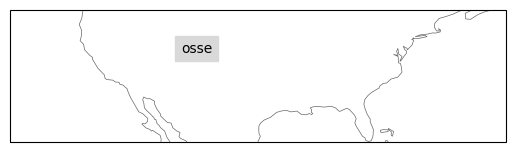

In [39]:
osse_poly = Polygon(US2)
ax = osse_region.plot(label="abbrev")
# fine tune the extent
ax.set_extent([225, 300, 25, 45], crs=ccrs.PlateCarree())
#osse_poly

In [40]:
path_snotel = '/Users/carina/Desktop/data/bcqc_snotel_data/'

def getsnotel_latlon():
    res = pd.DataFrame()
    for file_ in glob.glob("/Users/carina/Desktop/data/bcqc_snotel_data/*.txt"):
        with open(file_) as f:
            textf = " ".join(line.strip() for line in f)
        res = pd.concat([res,pd.DataFrame(data = {"filename" : [splitext(basename(file_))[0]], "stories" : [textf], "bcqc" : [bcqc]})])
    return res

In [41]:
dat.lat.size

621

In [42]:
# Step 1: get a list of all csv files in target directory
my_dir = '/Users/nicoleta/Desktop/data/bcqc_data/'
filelist = []
filesList = []
os.chdir(my_dir)

# Step 2: Build up list of files
for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filelist.append(fileName) #filename without extension
    filesList.append(files) #filename with extension

# Step 3: Build up the SNOTEL DataFrame 
df_snotel = DataFrame(filelist ,columns=['File_name'])
df_snotel['Lon'] = df_snotel.File_name.str.split('_').str[2]
df_snotel['Lat'] = df_snotel.File_name.str.split('_').str[1]


In [57]:
df_snotel

,File_name,Lon,Lat,geometry
0,bcqc_46.14000_-114.45000.txt,-114.45,46.14,POINT (-114.45000 46.14000)
1,bcqc_61.75000_-150.89000.txt,-150.89,61.75,POINT (-150.89000 61.75000)
2,bcqc_48.88000_-121.26000.txt,-121.26,48.88,POINT (-121.26000 48.88000)
3,bcqc_47.27000_-121.34000.txt,-121.34,47.27,POINT (-121.34000 47.27000)
4,bcqc_41.49000_-119.00000.txt,-119.00,41.49,POINT (-119.00000 41.49000)
...,...,...,...,...
828,bcqc_48.31000_-116.07000.txt,-116.07,48.31,POINT (-116.07000 48.31000)
829,bcqc_40.79000_-106.60000.txt,-106.60,40.79,POINT (-106.60000 40.79000)
830,bcqc_43.51000_-115.57000.txt,-115.57,43.51,POINT (-115.57000 43.51000)
831,bcqc_42.76000_-110.59000.txt,-110.59,42.76,POINT (-110.59000 42.76000)


In [96]:
def snotel_data(path_snotel):
    parts = path_snotel.split('_')
    lat = parts[2]
    lon = '.'.join(parts[3].split('.')[:-1])
    snotel_obs = pd.read_csv(path_snotel, sep='\s+', header=None)
    snotel_obs.columns = ['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F','SWE_in'] 
    snotel_obs['Tmean_C'] = (snotel_obs['Tmean_F'] - 32) * (5/9)
    snotel_obs['Lon'] = float(lon)
    snotel_obs['Lat'] = float(lat)
    snotel_obs['Date'] = pd.to_datetime(snotel_obs[['year', 'month', 'day']])
#     snotel_obs = snotel_obs.set_index(pd.DatetimeIndex(pd.to_datetime(snotel_obs[['year', 'month', 'day']])))
#     header_SWE = 'SWE_m_' + lat + '_' + lon
    snotel_obs['SWE_m'] = snotel_obs['SWE_in']*0.0254 #convert to m
    snotel_obs.drop(columns=['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F', 'SWE_in', 'Tmean_C'], inplace=True)
    snotel_obs.set_index(['Lat', 'Lon', 'Date'], inplace=True)
    return snotel_obs

In [97]:
#path_test = '/Users/carina/Desktop/data/snoho/bcqc_data/bcqc_40.54000_-106.68000_Colorado_Tower.txt'
path_test = '/Users/nicoleta/Desktop/data/bcqc_data/bcqc_40.43000_-105.73000.txt'
parts = path_test.split('_')
lat = parts[2]
lon = '.'.join(parts[3].split('.')[:-1])
#header_SWE = 'SWE_m_' + lat + lon
#header_SWE 
lon

'-105.73000'

In [98]:
parts

['/Users/nicoleta/Desktop/data/bcqc',
 'data/bcqc',
 '40.43000',
 '-105.73000.txt']

In [99]:
lat

'40.43000'

In [100]:
#change type 
df_snotel['Lon'] = df_snotel['Lon'].astype(float)
df_snotel['Lat'] = df_snotel['Lat'].astype(float)


In [101]:
#convert dataframe to point geodataframe 
gdf_snotel = gpd.GeoDataFrame(df_snotel, geometry = gpd.points_from_xy(x = df_snotel.Lon, y = df_snotel.Lat))

In [102]:
df_snotel['File_name'] = filesList

In [103]:
#df_snotel

In [104]:
lat_point_list = [40.715, 40.715, 37.525, 37.525]
lon_point_list = [-108.565, -105.025, -105.025, -108.565]

#polygon_geom = Polygon(zip(lat_point_list, lon_point_list))
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
#polygon_geom = zip(lon_list, lat_list)
crs = {'init': 'epsg:4326'}
gdf_poly = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       

points_within = gpd.sjoin(gdf_snotel, gdf_poly, op = 'within')

#polygon_geom = zip(lon_list, lat_list)


/opt/homebrew/Caskroom/miniforge/base/envs/compare_swe/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/homebrew/Caskroom/miniforge/base/envs/compare_swe/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_52862/800282138.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other

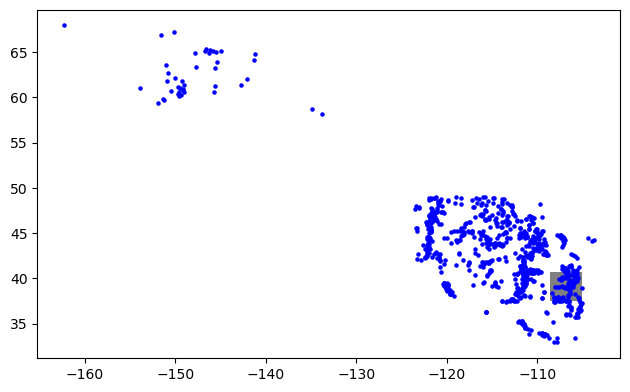

In [105]:
fig, ax = plt.subplots()

gdf_poly.plot(ax=ax, facecolor='gray');


gdf_snotel.plot(ax=ax, color='blue', markersize=5);

plt.tight_layout();

In [106]:
points_within.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 93 entries, 5 to 818
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   File_name    93 non-null     object  
 1   Lon          93 non-null     float64 
 2   Lat          93 non-null     float64 
 3   geometry     93 non-null     geometry
 4   index_right  93 non-null     int64   
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 4.4+ KB


In [107]:
points_within_paths = points_within['File_name'].tolist()

for i in range(0, len(points_within_paths)):
    points_within_paths[i] = '/Users/nicoleta/Desktop/data/bcqc_data/' + points_within_paths[i]

In [108]:
path

'/Users/nicoleta/Desktop/data/bcqc_data/bcqc_37.99000_-107.20000.txt'

In [109]:
dataframes = dict()
for path in points_within_paths:
    #snotel_data = snotel_data(path)
    dataframes[path] = snotel_data(path)

In [110]:
keys = list(dataframes.keys())

li = []

for key in keys:
    li.append(dataframes[key])
    
frame = pd.concat(li, axis=0)
frame.sort_index(inplace=True)
frame.head()

SWE_m
Lat   Lon     Date             
37.61 -105.37 2000-08-15    NaN
              2000-08-16    NaN
              2000-08-17    NaN
              2000-08-18    NaN
              2000-08-19    NaN

,SWE_m
Date,
1980-10-01,0.0
1980-10-02,0.0
1980-10-03,0.0
1980-10-04,0.0
1980-10-05,0.0


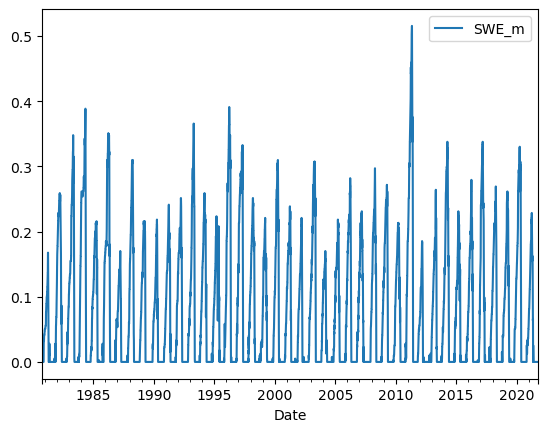

In [111]:
lon = -105.85000
lat = 40.40000
point_df = frame.xs((lat, lon))
point_df.plot()
point_df.head()

In [112]:
m = folium.Map(
    location = [40.715, -108.565],
    zoom_start = 12,
    tiles = 'Stamen Terrain'
)

folium.GeoJson(osse_poly).add_to(m)
folium.LatLngPopup().add_to(m)
tooltip = 'Click me!'

folium.Marker([37.7500, -107.6900], popup='<i>Molas Lake</i>', tooltip=tooltip).add_to(m)
folium.Marker([40.5400, -106.6900], popup='<b>Tower</b>', tooltip=tooltip).add_to(m)
folium.Marker([38.1600, -106.6000], popup='<b>Cochetopa Pass</b>', tooltip=tooltip).add_to(m)

df_snotel.apply(lambda row:folium.CircleMarker(location=[row["Lat"], 
                                                  row["Lon"]]).add_to(m),
     axis=1)

from folium.features import DivIcon

folium.map.Marker(
    [37.7500, -107.6900],
    popup='<i>Molas Lake</i>', tooltip=tooltip,
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Molas Lake</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [40.5400, -106.6900],
    popup='<i>Molas Lake</i>', tooltip=tooltip,
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Tower</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [38.1600, -106.6000],
    popup='<i>Molas Lake</i>', tooltip=tooltip,
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Cochetopa Pass</div>',
        )
    ).add_to(m)

m

In [113]:
#load and plot SNOTEL data 

path_Tower = '/Users/nicoleta/Desktop/data/bcqc_data/bcqc_40.54000_-106.68000.txt' #Colorado_Tower
path_Molas_Lake = '/Users/nicoleta/Desktop/data/bcqc_data/bcqc_37.75000_-107.69000.txt' #_Colorado_Molas_Lake.txt
path_Cochetopa_Pass = '/Users/nicoleta/Desktop/data/bcqc_data/bcqc_38.16000_-106.60000.txt'#_Colorado_Cochetopa_Pass.txt

def snotel_data(path_snotel):
    snotel_obs = pd.read_csv(path_snotel, sep='\s+', header=None)
    snotel_obs.columns = ['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F','SWE_in'] 
    snotel_obs['Tmean_C'] = (snotel_obs['Tmean_F'] - 32) * (5/9)
    snotel_obs = snotel_obs.set_index(pd.DatetimeIndex(pd.to_datetime(snotel_obs[['year', 'month', 'day']])))
    snotel_obs['SWE_m'] = snotel_obs['SWE_in']*0.0254
    return snotel_obs

In [114]:
snotel_Tower = snotel_data(path_Tower)
snotel_Molas_Lake = snotel_data(path_Molas_Lake)
snotel_Cochetopa_Pass = snotel_data(path_Cochetopa_Pass)

NameError: name 'datetime' is not defined

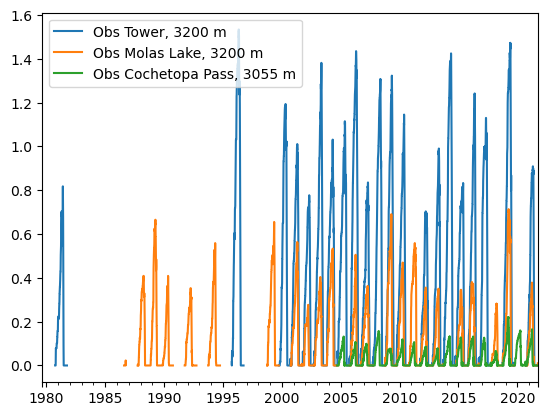

In [115]:
#plot SNOTELS: 
#ax = plt.gca()

ax = snotel_Tower.plot(kind='line',  y = 'SWE_m', label = 'Obs Tower, 3200 m')
snotel_Molas_Lake.plot(kind='line', y = 'SWE_m', label = 'Obs Molas Lake, 3200 m', ax = ax)
snotel_Cochetopa_Pass.plot(kind='line', y = 'SWE_m', label = 'Obs Cochetopa Pass, 3055 m', ax = ax)
ax.set_xlim([datetime(2005, 1, 21), datetime(2017, 12, 1)])
plt.xlabel('Time')
plt.ylabel('SWE [m]')

plt.show()

In [116]:
OSSEregions_poly = regionmask.Regions([osse_poly])
#OSSEregions_poly
mask_OSSE = OSSEregions_poly.mask(dat)

In [117]:
sel_mask = mask_OSSE.where(mask_OSSE == 0).values
sel_mask
lat = mask_OSSE.lat.values
lon = mask_OSSE.lon.values
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

In [118]:
out_sel1 = dat.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], 
                                                                    id_lon[-1])).compute().where(mask_OSSE == 0)

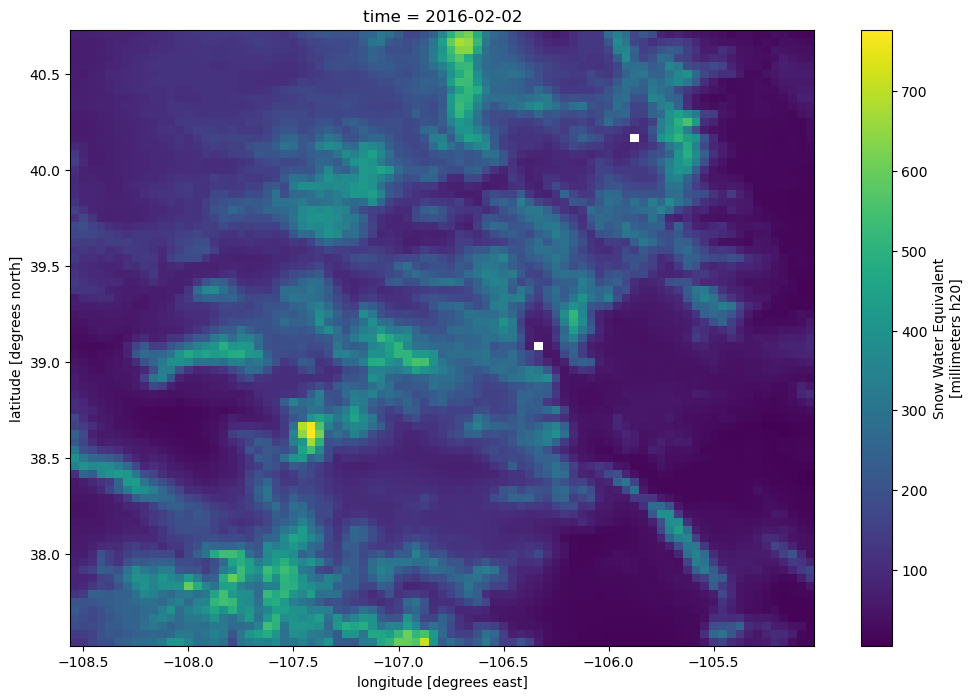

In [119]:
plt.figure(figsize=(12,8))
ax = plt.axes()
out_sel1.SWE.sel(time = '2016-02-02').plot()
#out_sel.mrro.isel(time = 1800).plot(ax = ax)
#basins.plot(ax = ax, alpha = 0.8, facecolor = 'none')